<a href="https://colab.research.google.com/github/ColeHenson/Data-Science24-25/blob/main/ColeHensU8Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vaccination Rates With BART

In [31]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [32]:
!pip install pymc-bart

# Data Rangling

In [33]:
counties = pd.read_csv("https://raw.githubusercontent.com/ColeHenson/Data-Science24-25/refs/heads/main/counties%20(1).csv")
counties

,name,fips,state,land_area (km^2),area (km^2),longitude (deg),latitude (deg),noaa/prcp,noaa/snow,noaa/temp,...,"industry/Agriculture, forestry, fishing and hunting/payroll","industry/Agriculture, forestry, fishing and hunting/employees",industry/Utilities/payroll,industry/Utilities/employees,industry/Management of companies and enterprises/payroll,industry/Management of companies and enterprises/employees,industry/Industries not classified/payroll,industry/Industries not classified/employees,"industry/Mining, quarrying, and oil and gas extraction/payroll","industry/Mining, quarrying, and oil and gas extraction/employees"
0,cuming county,31039,NE,1477.641638,1488.343176,-96.787366,41.916346,30.5,28.2,48.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lancaster county,31109,NE,2169.252486,2192.120047,-96.688211,40.784132,31.0,25.3,51.0,...,730000.0,111.0,8730000.0,95.0,165117000.0,2024.0,150000.0,3.0,NaN,NaN
2,nuckolls county,31129,NE,1489.645186,1491.363670,-98.047277,40.176383,27.7,22.2,51.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,keith county,31101,NE,2749.531887,2874.204062,-101.657059,41.198294,20.0,25.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,phelps county,31137,NE,1398.048570,1399.695104,-99.414593,40.513105,25.5,26.7,50.3,...,2557000.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,washington county,44009,RI,852.825659,1457.597303,-71.627758,41.385053,49.0,30.2,50.2,...,4339000.0,67.0,11574000.0,95.0,60844000.0,953.0,72000.0,3.0,3373000.0,44.0
3138,providence county,44007,RI,1060.791694,1128.431056,-71.569018,41.870350,52.6,46.7,49.2,...,521000.0,22.0,128342000.0,1101.0,975031000.0,11783.0,527000.0,15.0,7485000.0,97.0
3139,bristol county,44001,RI,62.513687,115.859939,-71.288552,41.704331,48.5,36.6,51.9,...,NaN,NaN,NaN,NaN,1919000.0,31.0,283000.0,4.0,NaN,NaN
3140,newport county,44005,RI,265.310311,812.295558,-71.286460,41.506366,47.4,36.6,51.6,...,1583000.0,29.0,5971000.0,75.0,10559000.0,225.0,346000.0,14.0,NaN,NaN


In [34]:
cov_data = ['name',
             'state',
             'population/2019',
             'life-expectancy',
             'poverty-rate',
             'edu/bachelors+',
             'avg_income',
             'elections/2020/total',
             'covid-vaccination/2021-12-01',
             'elections/2020/gop',
             'covid-deaths/2022-03-01',
             'covid-confirmed/2022-03-01',
             '65+',
             ]
sad_stats =  counties.loc[:,cov_data]

In [35]:
sdsts_nona = sad_stats.dropna()

In [36]:
sdsts_nona.insert(sdsts_nona.shape[1], "gop/pop", sdsts_nona['elections/2020/gop']/sdsts_nona['elections/2020/total'])
sdsts_nona.insert(sdsts_nona.shape[1], "cov/pop", sdsts_nona['covid-confirmed/2022-03-01']*10000/sdsts_nona['population/2019'])
sdsts_nona.insert(sdsts_nona.shape[1], "deaths/cases", sdsts_nona['covid-deaths/2022-03-01']/sdsts_nona['covid-confirmed/2022-03-01'])
sdsts_nona.drop(['elections/2020/gop'], axis=1, inplace=True)

<ipython-input-36-a0bc9a11bdca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdsts_nona.drop(['elections/2020/gop'], axis=1, inplace=True)


In [37]:
#vacination rates by county.
#I find out in a minute that vaccination rates are actually by state and not by county
cov = sdsts_nona['cov/pop'].to_numpy()
gop = sdsts_nona["gop/pop"].to_numpy()
po6 = sdsts_nona["65+"].to_numpy()
vac = sdsts_nona['covid-vaccination/2021-12-01'].to_numpy()

<Axes: >

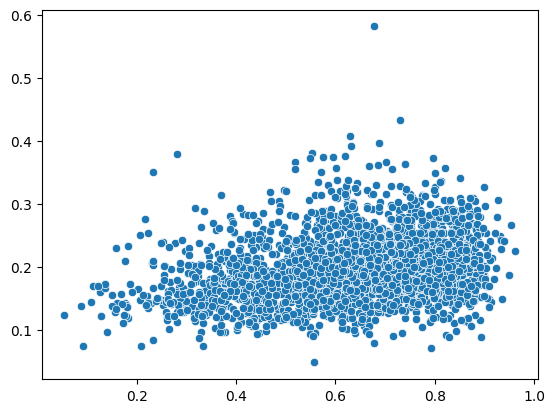

In [38]:
sns.scatterplot(x=gop, y=po6)

<Axes: >

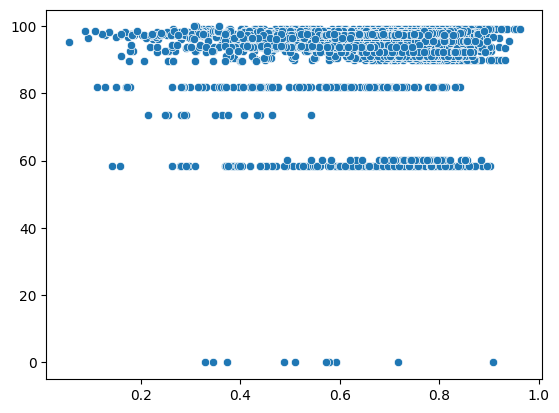

In [39]:
sns.scatterplot(x=gop, y=vac)


The data appears to take certain discrete values for the vaccination rate. This is because the vaccination rates are reported by state rather than by county. This means that it is going to be very difficult to use the data to find anything because the vaccination rates for the counties are simply incorrect. A given county has some impact on the vaccination rate for its state but that impact is negligable so instead of predicting vaccination rates I am going to try to predict death rates with the assumption that vaccines have a causal relationships with covid deaths in that they prevent deaths from covid. It's not a perfect replacement for vaccination rates, but presumably the death rate data contains some informaiton about vaccination rates

Ok now I have a collumn for deaths per 10000 cases. My assumption is that vaccination rates decrease death rates. But it is important to mention that there are a number of other factors like healthcare quality (outside of vaccination efforts) and individual health that need to be taken into account.

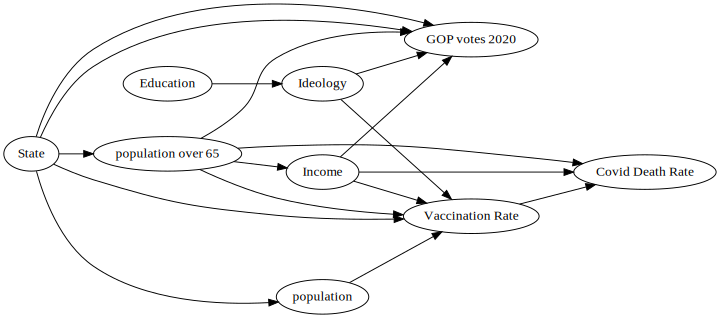

In [40]:
import graphviz
f = graphviz.Digraph('Covid dag', filename='Covid.gv')
f.attr(rankdir='LR', size='10,10')
#f is the graph f.node creates a node in the graph
f.node("Vaccination Rate")
f.node("Covid Death Rate")
f.node("population over 65")
f.node("State")
f.node("GOP votes 2020")
f.node("Ideology")
f.node("population")
f.edge("Vaccination Rate", "Covid Death Rate")
f.edge("population over 65", "Covid Death Rate")
f.edge("State", "Vaccination Rate")
f.edge("State", "GOP votes 2020")
f.edge("Ideology", "Vaccination Rate")
f.edge("Ideology", "GOP votes 2020")
f.edge("population over 65", "GOP votes 2020")
f.edge("population over 65", "Vaccination Rate")
f.edge("population", "Vaccination Rate")
f.edge("State", "population")
f.edge("State", "GOP votes 2020")
f.edge("State", "population over 65")
f.edge("Income", "Vaccination Rate")
f.edge("Income", "Covid Death Rate")
f.edge("population over 65", "Income")
f.edge("Income", "GOP votes 2020")
f.edge("Education", "Ideology")
display(f)

Ideology is an abstraction that I am not actually measuring. I included it in my DAG because it isn't precise to say that GOP votes cause Vaccination rates. I think it is closer to the truth to say that the ideological view that people should have the ability to choose whether they get a vaccine when vaccine mandates are being debated both causes  vaccination rates and GOP votes to change. The assumption I am making is that people's views impact both their voting and health choices. It may be true that voting Republican actually makes someone less likely to get vaccinated because they identify with a group, but I am not going to make that assumption because the vast majority of republicans are not antivaxxers. Age demographics are also a key element of my DAG. Demographics are a key predictor of world views on both politics, healthcare, and overall suseptability to infectious disease like covid.

In [41]:
import pymc_bart as pmb

In [42]:
#changed variables to be similar to notes
X=sdsts_nona[["65+"]].to_numpy()
Y=sdsts_nona["deaths/cases"].to_numpy()
Y=np.where(Y<=0,1e-6,Y)
invalid_indices = np.where(np.logical_or(np.isinf(np.log(Y)), np.isnan(np.log(Y))))[0]

# remove values that don't work with log (should be just negative values and values = 0)
X = np.delete(X, invalid_indices, axis=0)
Y = np.delete(Y, invalid_indices, axis=0)


In [43]:
with pm.Model() as cov_model:
  #copied from notes
    s = pm.HalfNormal('s',10)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_cov = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

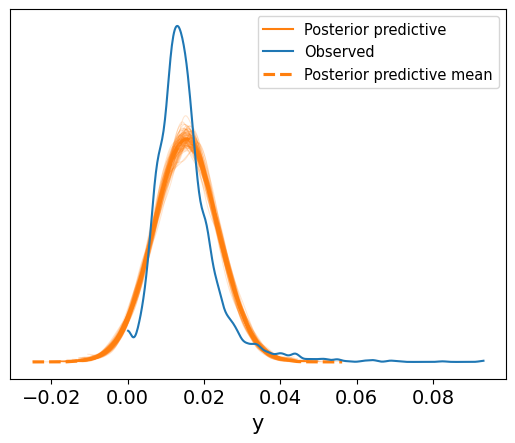

In [44]:
pm.sample_posterior_predictive(idata_cov,cov_model, extend_inferencedata=True)
az.plot_ppc(idata_cov, num_pp_samples=100, colors=["C1", "C0", "C1"])

As an initial model this isn't very good. I am getting a much lower probability for counties with the mode number of deaths per case. I am also getting a non 0 probability of negative numbers of deaths per 10,000 covid cases which doesn't make sense unless I think that there is a chance that getting covid saves people's lives in certain counties more than it kills them. I don't.

In [45]:
# now my 3 predictors are p/65, pop and gop
Z = sdsts_nona[["65+","gop/pop", "population/2019"]].to_numpy()

In [46]:
#model time
with pm.Model() as cov_model2:
  s = pm.HalfNormal('s',10)
  μ_ = pmb.BART("μ_", Z, np.log(Y), m=50) #log around Y
  μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
  y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
  idata_cov2 = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

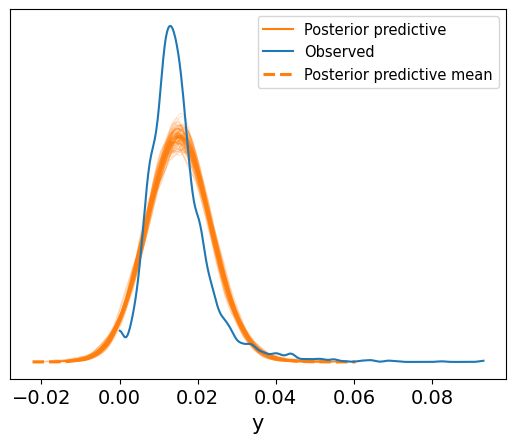

In [47]:
pm.sample_posterior_predictive(idata_cov2,cov_model2, extend_inferencedata=True)
az.plot_ppc(idata_cov2, num_pp_samples=100, colors=["C1", "C0", "C1"])

Ok this looks exactly the same. My guess is that this is because there is a high correlation between gop, pop and 65+. My guess is that this has something to do with the way Bart is handling my predictor variables. If all the predictors are correlated then Bart will reduce their weights and since the predictor variables are already only part of my priors, they simply will not make a difference in my model.

In [48]:
posterior_mean = idata_cov2.posterior["μ"]

μ_hdi = az.hdi(ary=idata_cov2, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_cov2, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


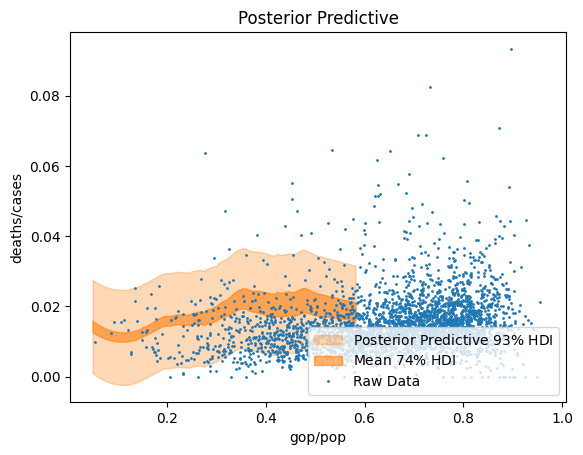

In [49]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Z[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=Z[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(sdsts_nona["gop/pop"], sdsts_nona["deaths/cases"], "o", c="C0", label="Raw Data", markersize=1)
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="gop/pop",
    ylabel="deaths/cases",
);

Not sure why I am getting only half the HDI. The sections I have don't look accurate and the mean 74% HDI is too skinny. Looking at the HDI this data doesn't seem to show a relationship between gop/pop and deaths/cases. Frankly just looking at the scatter plot there doesn't seem to be much of a relationship in general.

In [50]:
A = sdsts_nona[["65+", "population/2019", "avg_income", "edu/bachelors+"]]

In [51]:
#same as model before but this time with income and education
with pm.Model() as cov_model3:
    s = pm.HalfNormal('s', 10) #prior for sigma
    μ_ = pmb.BART("μ_", A, np.log(Y), m=50) #BART prior around the log of Y
    μ = pm.Deterministic("μ", pm.math.exp(μ_)) #exponentiate it once BART is done
    y = pm.Normal("y", mu=μ, sigma=s, observed=Y) #likelihood
    idata_cov3 = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

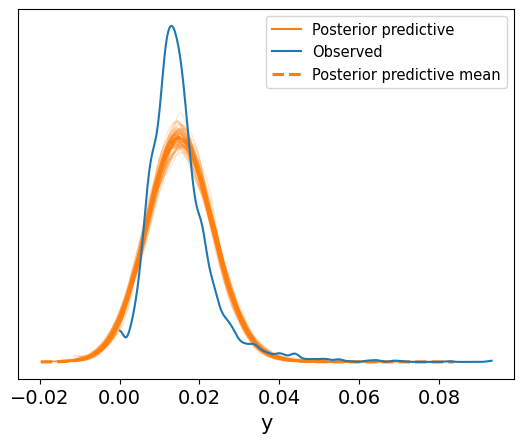

In [52]:
pm.sample_posterior_predictive(idata_cov3,cov_model3, extend_inferencedata=True)
az.plot_ppc(idata_cov3, num_pp_samples=100, colors=["C1", "C0", "C1"])

This is still not very good. I am still not getting a high enough probability for the mode number covid deaths per 10,000 cases. I wanted to try and use a Gamma or inverse gamma distribution instead of a normal for my likelyhood, but I couldn't get it to run. One possibility that is messing with the data is that for some states some of the data is collected in the same way it is for covid vaccination rates i.e state values are generalized to counties.

In [53]:
#same as model before but this time with no bart trees. I tried this on accident
#and the result seemed better
with pm.Model() as cov_model4:
    s = pm.HalfNormal('s', 10) #prior for sigma
    μ_ = pmb.BART("μ_", A, np.log(Y), m=0) #BART prior around the log of Y
    μ = pm.Deterministic("μ", pm.math.exp(μ_)) #exponentiate it once BART is done
    y = pm.Normal("y", mu=μ, sigma=s, observed=Y) #likelihood
    idata_cov4 = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

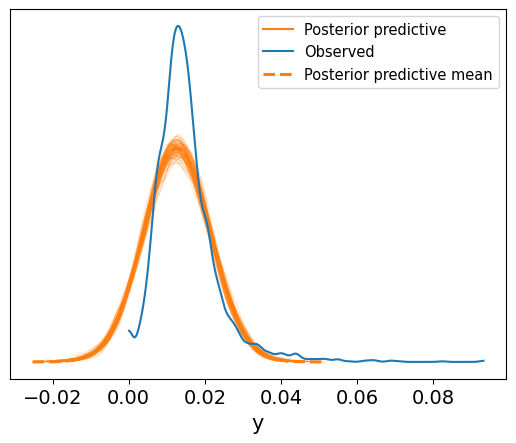

In [54]:
pm.sample_posterior_predictive(idata_cov4,cov_model4, extend_inferencedata=True)
az.plot_ppc(idata_cov4, num_pp_samples=100, colors=["C1", "C0", "C1"])

I got the same result as before, but now the graph is more centered. What this is telling me is that maybe the relationship isn't complex enough to justify using a Bart model. I can make the argument that the Bart model is slightly better, however, because it actually does a better job of not predicting negative death rates on account being slightly shifted to the right.

In [81]:
B = sdsts_nona[["65+", "population/2019", "avg_income", "edu/bachelors+"]]
Y = sdsts_nona["gop/pop"].to_numpy()

So far I haven't had any success. I suspect the reason why is that covid death rates are mostly caused by randomness so it doesn't make sense to try to predict it with other variables. Instead I am going to try and predict gop/pop with population, 65+, avg_income, and education

In [83]:
with pm.Model() as cov_model5:
    s = pm.HalfNormal('s', 10) #prior for sigma
    μ_1 = pmb.BART("μ_", B, np.log(Y), m=50) #BART prior around the log of Y
    μ = pm.Deterministic("μ", pm.math.exp(μ_1)) #exponentiate it once BART is done
    y = pm.Normal("y", mu=μ, sigma=s, observed=Y) #likelihood
    idata_cov5 = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

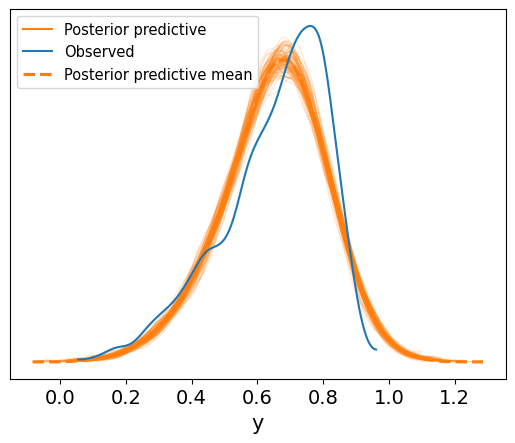

In [71]:
pm.sample_posterior_predictive(idata_cov5,cov_model5, extend_inferencedata=True)
az.plot_ppc(idata_cov5, num_pp_samples=100, colors=["C1", "C0", "C1"])

This is actually pretty good. There is a bit of left skew, but for the most part the model matches the data. I think the skew is caused because the counties with small gops/pops are different from the other counties in that they are generally big cities. Thus there are more people represented in them so the distribution of voters is more normal than the distribution of counties.

array([<Axes: xlabel='65+'>, <Axes: xlabel='population/2019'>,
       <Axes: xlabel='avg_income'>, <Axes: xlabel='edu/bachelors+'>],
      dtype=object)

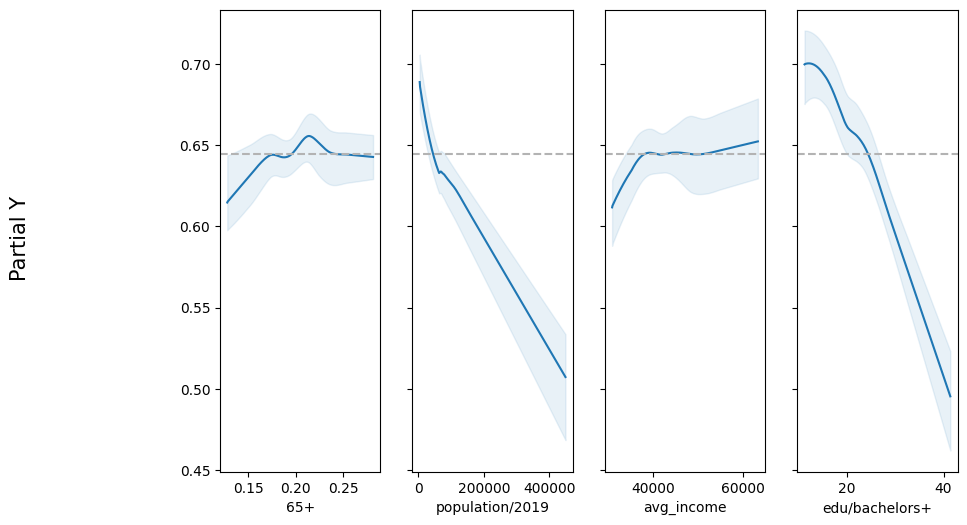

In [84]:
pmb.plot_pdp(μ_1, B, Y, grid=(1, 5), func=np.exp, figsize=(12, 6))

Based on the pdp plots population and educaiton have a strong negative linear relationship with gop votes. This aligns with my prior knowledge that population dense regions and places with high levels of education tend to vote more democrat than republican.

array([<Axes: xlabel='65+'>, <Axes: xlabel='population/2019'>,
       <Axes: xlabel='avg_income'>, <Axes: xlabel='edu/bachelors+'>],
      dtype=object)

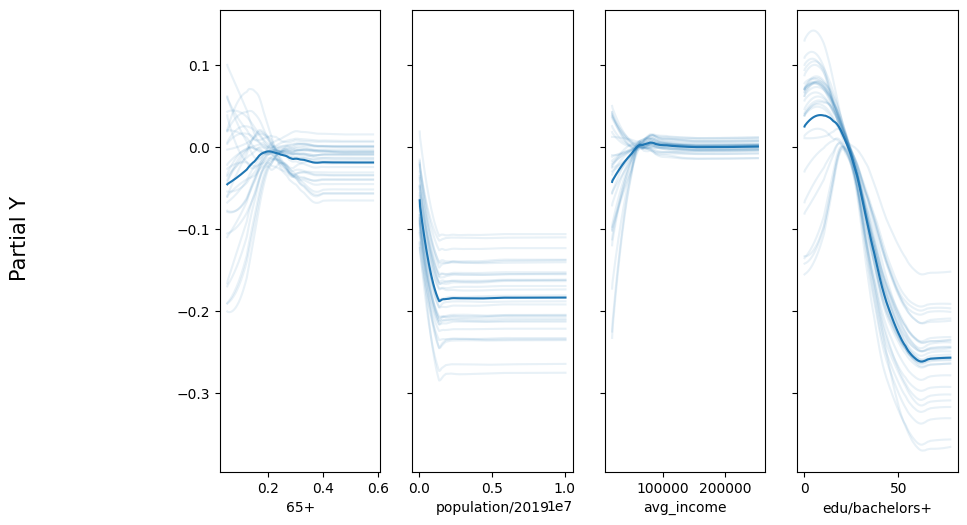

In [86]:
pmb.plot_ice( μ_1, B, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

The age and income variable have a lot of interactions evidenced by the high tendency of the lines to cross. I would expect this based on my knowlege that the population density of a region has a large impact on people's income and age has a large impact with a lot of factors including education since the numbers of people that go to college has increased ove the years. Again, no real surprises here.

In [88]:
vi_cov = pmb.compute_variable_importance(idata_cov5, μ_1, B)

<Axes: ylabel='R²'>

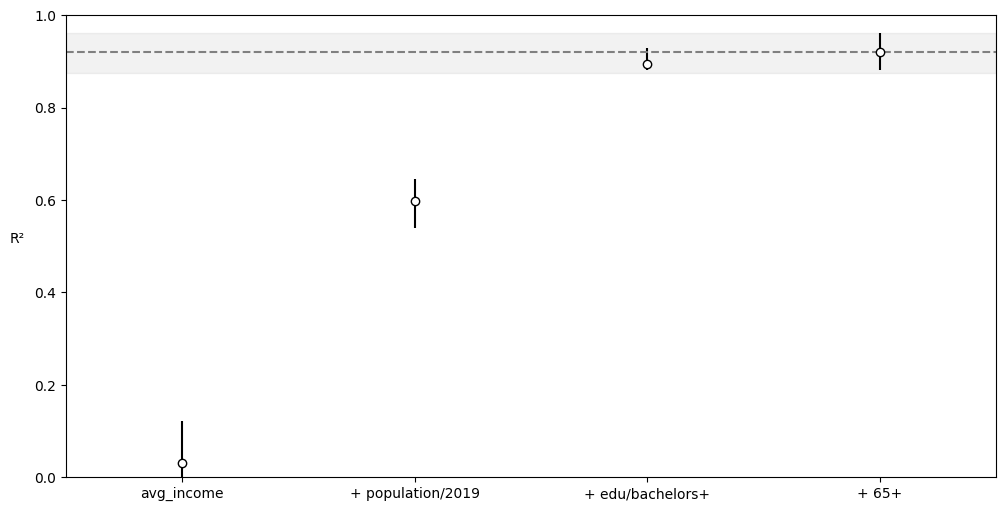

In [89]:
pmb.plot_variable_importance(vi_cov, figsize=(12, 6))

Evidently adding population and education had the greatest impact on the gop/pop. This is not surprising since that is the relationship I saw with my pdp plots. Probably a model with just population and education would do almost as well and be simpler than the model I have now.

# Conclusion

I had a lot of stuggles getting the covid death rates models to work. I think this is because the odds of a certain number of people dying to covid in are mostly random regaurdless of what county they are in. Furthermore a small county might have one covid case and one death producing an extremely high death rate and thus throwing off the data. I then decided to try to predict voting patterns based on demographic measurments since I am confortable with my prior knowledge on that issue and I wanted to get all the new plots we added this unit to work for my model. Ultimately educaiton and population size had the greatest predictive power for that model. I think the main thing I learned from this project was that it is important to be organized with data cleaning. When I did my first models on covid, I basically recleaned the data every time I made a new model and I had a lot of problems related to needing to remove nan values multiple times. By going back and organizing my data cleaning in one place, the project went a lot faster and I came to understand the space I was creating my models in better.